In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aerial-cactus-identification/sample_submission.csv
/kaggle/input/aerial-cactus-identification/train.zip
/kaggle/input/aerial-cactus-identification/test.zip
/kaggle/input/aerial-cactus-identification/train.csv


In [2]:
data_path = '/kaggle/input/aerial-cactus-identification/'
labels = pd.read_csv(data_path+'train.csv')
submission = pd.read_csv(data_path+'sample_submission.csv')

In [3]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


([<matplotlib.patches.Wedge at 0x7f2a588dfc10>,
 [Text(-0.7793519565739234, 0.7762799287527649, 'Has cactus'),
  Text(0.7793519929142085, -0.776279892268666, "Hasn't cactus")],
 [Text(-0.42510106722213997, 0.42342541568332626, '75.1%'),
  Text(0.4251010870441137, -0.42342539578290866, '24.9%')])

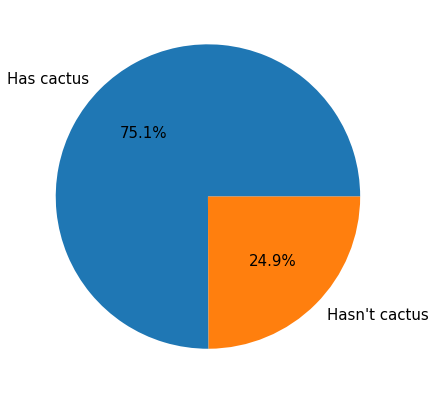

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Has cactus', 'Hasn\'t cactus']
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%.1f%%')

In [6]:
from zipfile import ZipFile

with ZipFile(data_path+'train.zip') as zipper :
    zipper.extractall()

with ZipFile(data_path+'test.zip') as zipper :
    zipper.extractall()

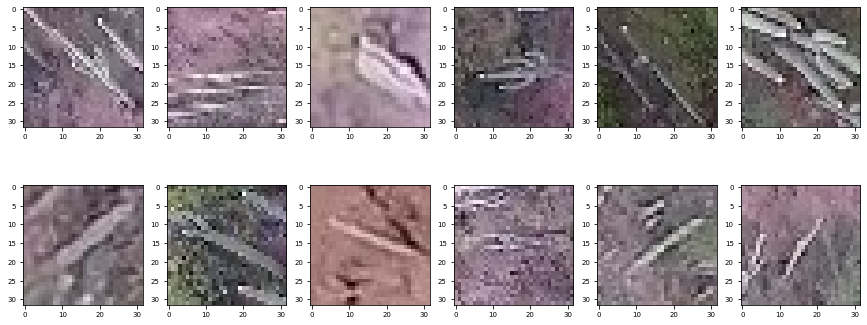

In [7]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name) :
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

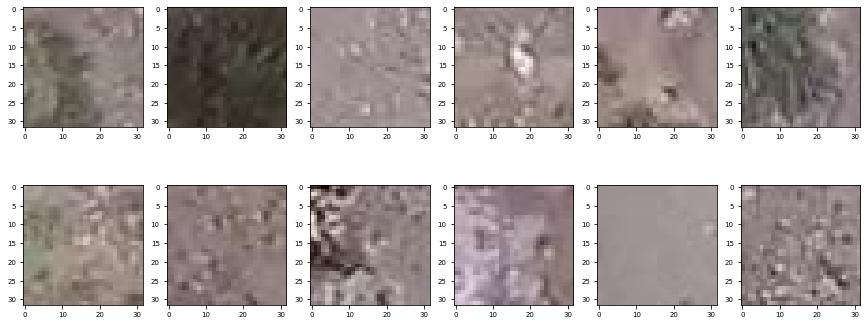

In [8]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name) :
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

In [9]:
import torch
import random
import numpy as np
import os

seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [10]:
if torch.cuda.is_available() :
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

In [11]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(labels, test_size=0.1, stratify=labels['has_cactus'], random_state=50)

In [12]:
print('훈련 데이터 개수', len(train))
print('검증 데이터 개수', len(valid))

훈련 데이터 개수 15750
검증 데이터 개수 1750


In [13]:
from torch.utils.data import Dataset

class ImageDataset(Dataset) :
    def __init__(self, df, img_dir='./', transform=None) :
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self) :
        return len(self.df)
    
    def __getitem__(self, idx) :
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label =self.df.iloc[idx, 1]
        
        if self.transform is not None :
            image = self.transform(image)
        return image, label

In [14]:
from torchvision import transforms

transform = transforms.ToTensor()

transform_train = transforms.Compose([transforms.ToTensor(),
                                     transforms.Pad(32,padding_mode='symmetric'),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomRotation(10),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Pad(32,padding_mode='symmetric'),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

In [15]:
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform_test)
                             

In [16]:
from torch.utils.data import DataLoader

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class Model(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2), nn.BatchNorm2d(32), nn.LeakyReLU(), nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2), nn.BatchNorm2d(64), nn.LeakyReLU(), nn.MaxPool2d(kernel_size=2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2), nn.BatchNorm2d(128), nn.LeakyReLU(), nn.MaxPool2d(kernel_size=2))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2), nn.BatchNorm2d(256), nn.LeakyReLU(), nn.MaxPool2d(kernel_size=2))
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2), nn.BatchNorm2d(512), nn.LeakyReLU(), nn.MaxPool2d(kernel_size=2))
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.fc1 = nn.Linear(in_features=512 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)
        
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)
        
    def forward(self, x) :
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [19]:
model = Model().to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

In [22]:
epochs = 70
for epoch in range(epochs) :
    epoch_loss = 0
    
    for images, labels in loader_train :
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print(f'에폭 [{epoch + 1}/{epochs}] - 손실값 : {epoch_loss/len(loader_train):.4f}')

에폭 [1/70] - 손실값 : 0.1303
에폭 [2/70] - 손실값 : 0.0684
에폭 [3/70] - 손실값 : 0.0517
에폭 [4/70] - 손실값 : 0.0420
에폭 [5/70] - 손실값 : 0.0360
에폭 [6/70] - 손실값 : 0.0322
에폭 [7/70] - 손실값 : 0.0303
에폭 [8/70] - 손실값 : 0.0260
에폭 [9/70] - 손실값 : 0.0269
에폭 [10/70] - 손실값 : 0.0263
에폭 [11/70] - 손실값 : 0.0222
에폭 [12/70] - 손실값 : 0.0236
에폭 [13/70] - 손실값 : 0.0195
에폭 [14/70] - 손실값 : 0.0180
에폭 [15/70] - 손실값 : 0.0185
에폭 [16/70] - 손실값 : 0.0169
에폭 [17/70] - 손실값 : 0.0149
에폭 [18/70] - 손실값 : 0.0156
에폭 [19/70] - 손실값 : 0.0147
에폭 [20/70] - 손실값 : 0.0136
에폭 [21/70] - 손실값 : 0.0152
에폭 [22/70] - 손실값 : 0.0142
에폭 [23/70] - 손실값 : 0.0151
에폭 [24/70] - 손실값 : 0.0114
에폭 [25/70] - 손실값 : 0.0125
에폭 [26/70] - 손실값 : 0.0114
에폭 [27/70] - 손실값 : 0.0116
에폭 [28/70] - 손실값 : 0.0113
에폭 [29/70] - 손실값 : 0.0116
에폭 [30/70] - 손실값 : 0.0103
에폭 [31/70] - 손실값 : 0.0107
에폭 [32/70] - 손실값 : 0.0099
에폭 [33/70] - 손실값 : 0.0096
에폭 [34/70] - 손실값 : 0.0091
에폭 [35/70] - 손실값 : 0.0099
에폭 [36/70] - 손실값 : 0.0100
에폭 [37/70] - 손실값 : 0.0081
에폭 [38/70] - 손실값 : 0.0061
에폭 [39/70] - 손실값 : 0.

In [23]:
from sklearn.metrics import roc_auc_score

true_list = []
pred_list = []

In [24]:
model.eval()

with torch.no_grad() :
    for images, labels in loader_valid :
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        pred = torch.softmax(outputs.cpu(), dim=1)[:, 1]
        true = labels.cpu()
        
        pred_list.extend(pred)
        true_list.extend(true)

print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, pred_list) : .4f}')

검증 데이터 ROC AUC :  0.9998


In [25]:
dataset_test = ImageDataset(df=submission, img_dir='test/', transform=transform_test)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

In [26]:
model.eval()

preds = []

with torch.no_grad() :
    for images, labels in loader_test :
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        pred_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        
        preds.extend(pred_part)

In [27]:
len(preds)

4000

In [28]:
submission.shape

(4000, 2)

In [29]:
submission['has_cactus'] = preds
submission.to_csv('submission.csv', index=False)

In [30]:
import shutil
shutil.rmtree('./train')
shutil.rmtree('./test')